In [21]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from textwrap import wrap

from tti_explorer.strategies.common import RETURN_KEYS

import sys; sys.path.append("../scripts/charts")
from chart_books import *

plt.style.use("seaborn-ticks")

perc_formatter = FuncFormatter(lambda x, _: f"{x:.0f}%")
formatters = {
    'app_cov': perc_formatter,
    'trace_adherence': perc_formatter    
}

In [22]:
raw_data = pd.read_csv('../runs/1_2a_results_smaller_covid_2/all_results.csv', index_col=[0,2])

In [23]:
columns = [
    RETURN_KEYS.stopped_by_social_distancing_percentage,
    RETURN_KEYS.stopped_by_symptom_isolating_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
    RETURN_KEYS.not_stopped_asymptomatic_percentage,
    RETURN_KEYS.not_stopped_symptomatic_non_compliant_percentage,
    RETURN_KEYS.not_stopped_by_tti_percentage,
]

keys = ["S1_test_based_TTI", "S2_test_based_TTI", "S3_test_based_TTI", "S4_test_based_TTI", "S5_test_based_TTI"]

data = raw_data[columns]
data = data.loc[keys].copy()

data.index.get_level_values(0)
data.index = pd.MultiIndex.from_arrays([
    [k.split('_')[0] for k in data.index.get_level_values(0)],
    data.index.get_level_values(1)
], names=['NPI Stringency Level', 'statistic'])

data.columns = [
    "Prevented by social distancing",
    "Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts",
    "Prevented by tracing and quarantine of extra-household secondary contacts",
    "Transmissions from asymptomatic index cases",
    "Transmissions from never-reporting symptomatic index cases",
    "Transmissions from reporting index cases",
]

data = data[[
    "Transmissions from asymptomatic index cases",
    "Transmissions from never-reporting symptomatic index cases",
    "Transmissions from reporting index cases",
    "Prevented by tracing and quarantine of extra-household secondary contacts",
    "Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts",
    "Prevented by social distancing",
]]

# Change % to R
data = data * 0.0392

data.xs('mean', level=1)

Transmissions from asymptomatic index cases  \
NPI Stringency Level                                                
S5                                                       0.353057   
S4                                                       0.481045   
S3                                                       0.645764   
S2                                                       0.828091   
S1                                                       0.950007   

                      Transmissions from never-reporting symptomatic index cases  \
NPI Stringency Level                                                               
S5                                                             0.204549            
S4                                                             0.299203            
S3                                                             0.417476            
S2                                                             0.512798            
S1                                                             0.564224            

                      Transmissions from reporting index cases  \
NPI Stringency Level                                             
S5                                                    0.129268   
S4                                                    0.184976   
S3                                                    0.277510   
S2                                                    0.367256   
S1                                                    0.474425   

                      Prevented by tracing and quarantine of extra-household secondary contacts  \
NPI Stringency Level                                                                              
S5                                                             0.086313                           
S4                                                             0.156527                           
S3                                                             0.223242                           
S2                                                             0.280076                           
S1                                                             0.308087                           

                      Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts  \
NPI Stringency Level                                                                                                                     
S5                                                             0.629025                                                                  
S4                                                             0.854642                                                                  
S3                                                             1.111776                                                                  
S2                                                             1.391598                                                                  
S1                                                             1.623258                                                                  

                      Prevented by social distancing  
NPI Stringency Level                                  
S5                                          2.517788  
S4                                          1.943607  
S3                                          1.244231  
S2                                          0.540181  
S1                                          0.000000

In [80]:
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_hashed_bars(
    df, 
    hatch_indicies, 
    color_cycle=default_colors, 
    x_label=None,
    y_label="R", 
    text_wrap_chars=40, 
    save_fig=None
):

    ax = df.plot(
        kind='bar', 
        stacked=True, 
        color=color_cycle, 
        alpha=.7,
        hatch='',
        legend=False
    )
    # ax.yaxis.set_major_formatter(perc_formatter)
    plt.xticks(rotation=0)
    if x_label is not None:
        plt.x_label(x_label)
    
    if y_label is not None:
        plt.ylabel(y_label)

    for i, child in enumerate(ax.get_children()):
        if isinstance(child, matplotlib.patches.Rectangle):
            if i // len(df) in hatch_indicies:
                child.set_hatch('//')

    plt.tight_layout()
    plt.gcf().set_size_inches(5.4, 3.8)

    if save_fig is not None:
        plt.savefig(f'{save_fig}.pdf', bbox_inches='tight')
        # plt.savefig(f'{save_fig}.png', bbox_extra_artists=(legend,), bbox_inches='tight', dpi=400)

    plt.show()

    handles, labels = ax.get_legend_handles_labels()
    labels = [ '\n'.join(wrap(l, text_wrap_chars)) for l in labels]
    legend = plt.legend(
        handles[::-1], 
        labels[::-1],
        bbox_to_anchor=(1,1),
        framealpha=0.5, 
        fontsize=12, 
        loc="upper left", 
        labelspacing=1.3
    )
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # plt.show()

    if save_fig is not None:
        plt.savefig(f'{save_fig}_legend.pdf', bbox_inches=bbox)

    plt.show()

In [81]:
def plot_lines(
    df,
    color_cycle=default_colors, 
    x_label=None,
    y_label="% of Ongoing Transmission", 
    text_wrap_chars=40, 
    save_fig=None
):
    ax = df.plot(
    kind='line',
    color=color_cycle,
    alpha=.7,
    marker='x',
    legend=False
    )

    ax.yaxis.set_major_formatter(perc_formatter)

    if x_label is not None:
        plt.x_label(x_label)
    
    if y_label is not None:
        plt.ylabel(y_label)

    plt.tight_layout()
    plt.gcf().set_size_inches(5.4, 3.8)

    if save_fig is not None:
        plt.savefig(f'{save_fig}.pdf', bbox_inches='tight')
        # plt.savefig(f'{save_fig}.png', bbox_extra_artists=(legend,), bbox_inches='tight', dpi=400)

    plt.show()

    handles, labels = ax.get_legend_handles_labels()
    labels = [ '\n'.join(wrap(l, text_wrap_chars)) for l in labels]
    legend = plt.legend(
        handles[::-1], 
        labels[::-1],
        bbox_to_anchor=(1,1),
        framealpha=0.5, 
        fontsize=12, 
        loc="upper left", 
        labelspacing=1.3
    )
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # plt.show()

    if save_fig is not None:
        plt.savefig(f'{save_fig}_legend.pdf', bbox_inches=bbox)

    plt.close()
    
    # fig.savefig(filename, dpi="figure", bbox_inches=bbox)


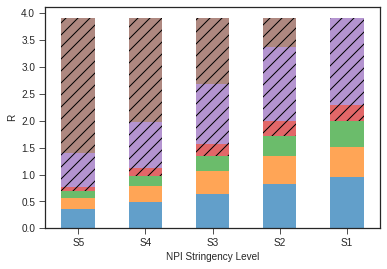

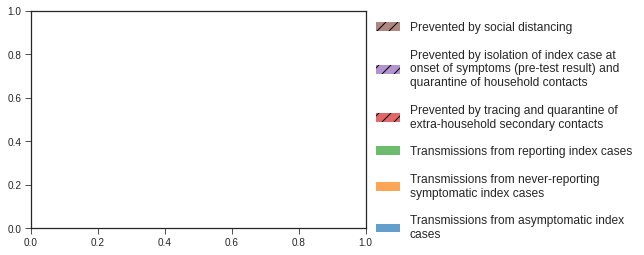

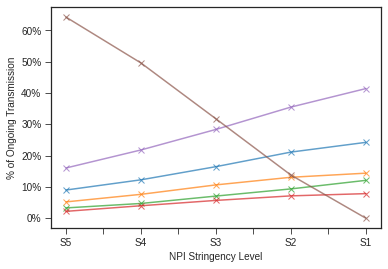

In [82]:
plot_hashed_bars(data.xs('mean', level=1), [3,4,5], save_fig='../outputs/charts/secondry_cases_including_social_distancing_stacked_bar')
plot_lines(data.xs('mean', level=1) / 0.0392, save_fig='../outputs/charts/secondry_cases_including_social_distancing_line')

In [83]:
columns = [
    RETURN_KEYS.stopped_by_symptom_isolating_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
    RETURN_KEYS.not_stopped_asymptomatic_percentage,
    RETURN_KEYS.not_stopped_symptomatic_non_compliant_percentage,
    RETURN_KEYS.not_stopped_by_tti_percentage,
]

keys = ["S1_test_based_TTI", "S2_test_based_TTI", "S3_test_based_TTI", "S4_test_based_TTI", "S5_test_based_TTI"]

renormed_data = raw_data[columns]
renormed_data = renormed_data.loc[keys].copy()

renormed_data.index = pd.MultiIndex.from_arrays([
    [k.split('_')[0] for k in renormed_data.index.get_level_values(0)],
    renormed_data.index.get_level_values(1)
], names=['NPI Stringency Level', 'statistic'])


normalisers = (renormed_data.xs('mean', level=1).sum(axis=1)/100).repeat(2).values

renormed_data = renormed_data.div(normalisers, axis=0)

renormed_data.columns = [
    "Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts",
    "Prevented by tracing and quarantine of extra-household secondary contacts",
    "Transmissions from asymptomatic index cases",
    "Transmissions from never-reporting symptomatic index cases",
    "Transmissions from reporting index cases",
]

renormed_data = renormed_data[[
    "Transmissions from asymptomatic index cases",
    "Transmissions from never-reporting symptomatic index cases",
    "Transmissions from reporting index cases",
    "Prevented by tracing and quarantine of extra-household secondary contacts",
    "Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts",
]]

# Change % to R
renormed_data = renormed_data * 0.0392

renormed_data

Transmissions from asymptomatic index cases  \
NPI Stringency Level statistic                                                
S5                   mean                                      9.870015e-01   
                     std                                       2.398350e-13   
S4                   mean                                      9.541091e-01   
                     std                                       1.281851e-12   
S3                   mean                                      9.460443e-01   
                     std                                       1.571321e-12   
S2                   mean                                      9.604412e-01   
                     std                                       1.538404e-12   
S1                   mean                                      9.500068e-01   
                     std                                       2.037434e-12   

                                Transmissions from never-reporting symptomatic index cases  \
NPI Stringency Level statistic                                                               
S5                   mean                                            5.718329e-01            
                     std                                             4.114608e-13            
S4                   mean                                            5.934431e-01            
                     std                                             1.261890e-12            
S3                   mean                                            6.116022e-01            
                     std                                             6.441968e-13            
S2                   mean                                            5.947567e-01            
                     std                                             8.202466e-13            
S1                   mean                                            5.642240e-01            
                     std                                             6.150600e-13            

                                Transmissions from reporting index cases  \
NPI Stringency Level statistic                                             
S5                   mean                                   3.613788e-01   
                     std                                    7.535717e-14   
S4                   mean                                   3.668830e-01   
                     std                                    2.366785e-13   
S3                   mean                                   4.065521e-01   
                     std                                    2.612492e-13   
S2                   mean                                   4.259526e-01   
                     std                                    4.225532e-13   
S1                   mean                                   4.744245e-01   
                     std                                    7.503558e-13   

                                Prevented by tracing and quarantine of extra-household secondary contacts  \
NPI Stringency Level statistic                                                                              
S5                   mean                                            2.412962e-01                           
                     std                                             4.014233e-13                           
S4                   mean                                            3.104575e-01                           
                     std                                             2.829676e-13                           
S3                   mean                                            3.270499e-01                           
                     std                                             5.784462e-13                           
S2                   mean                                            3.248389e-01                           
                     std                                    

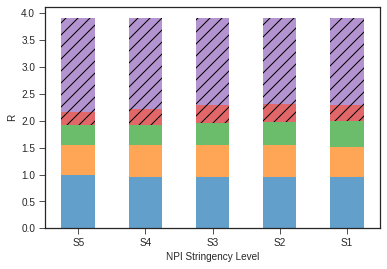

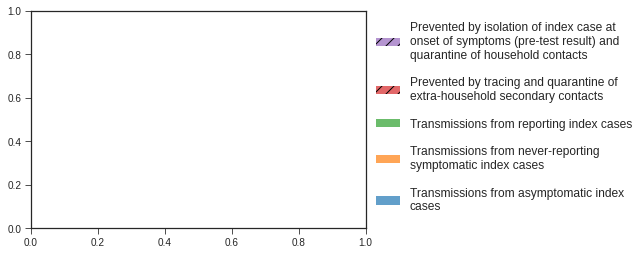

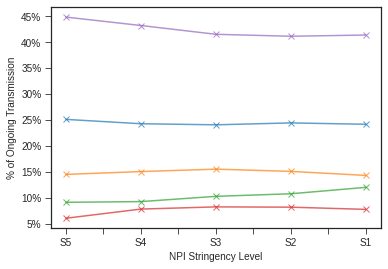

In [84]:
plot_hashed_bars(renormed_data.xs('mean', level=1), [3,4], save_fig='../outputs/charts/secondry_cases_not_including_social_distancing_stacked_bar')
plot_lines(renormed_data.xs('mean', level=1) / 0.0392, save_fig='../outputs/charts/secondry_cases_not_including_social_distancing_line')

In [93]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from textwrap import wrap

from tti_explorer.strategies.common import RETURN_KEYS

import sys; sys.path.append("../scripts/charts")
from chart_books import *

plt.style.use("seaborn-ticks")

columns = [
    RETURN_KEYS.stopped_by_social_distancing_percentage,
    RETURN_KEYS.stopped_by_symptom_isolating_percentage,
    RETURN_KEYS.stopped_by_tracing_percentage,
    RETURN_KEYS.not_stopped_asymptomatic_percentage,
    RETURN_KEYS.not_stopped_symptomatic_non_compliant_percentage,
    RETURN_KEYS.not_stopped_by_tti_percentage,
]

columns_pretty_names = [
    "(f) Prevented by social distancing",
    "(e) Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts",
    "(d) Prevented by tracing and quarantine of extra-household secondary contacts",
    "(a) Transmissions from asymptomatic index cases",
    "(b) Transmissions from never-reporting symptomatic index cases",
    "(c) Transmissions from reporting index cases",
]

columns_order = [
    "(f) Transmissions from asymptomatic index cases",
    "(e) Transmissions from never-reporting symptomatic index cases",
    "(d) Transmissions from reporting index cases",
    "(c) Prevented by tracing and quarantine of extra-household secondary contacts",
    "(a) Prevented by isolation of index case at onset of symptoms (pre-test result) and quarantine of household contacts",
    "(b) Prevented by social distancing",
]

def load_sensitivity_folder(outputs_dir, config_keys, config_pretty_names):
    sensitivity_data = pd.DataFrame()

    files = glob.glob(os.path.join(outputs_dir, '*.json'))
    files = [int(k.split('_')[-1].split('.')[0]) for k in files]

    for i in files:
        with open(os.path.join(outputs_dir, f'config_{i}.json'), 'r') as file:
            cfg = json.load(file)
        results = pd.read_csv(os.path.join(outputs_dir, f'run_{i}.csv'))
        for key, name in zip(config_keys, config_pretty_names):
            results[name] = cfg["config"][key]
        # print(cfg["config"][config_key])
        sensitivity_data = pd.concat([sensitivity_data, results])

    sensitivity_data = sensitivity_data.round(2)
    sensitivity_data.sort_values(by=config_pretty_names, inplace=True)

    sensitivity_data.set_index([*config_pretty_names, 'statistic'], inplace=True)
    sensitivity_data = sensitivity_data[columns]
    sensitivity_data.columns = columns_pretty_names
    sensitivity_data = sensitivity_data[columns_order]
    # change % to R
    return sensitivity_data


1


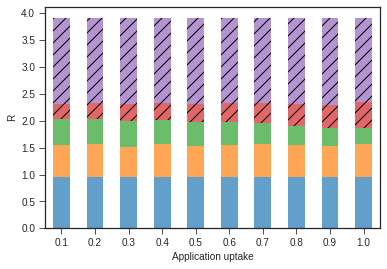

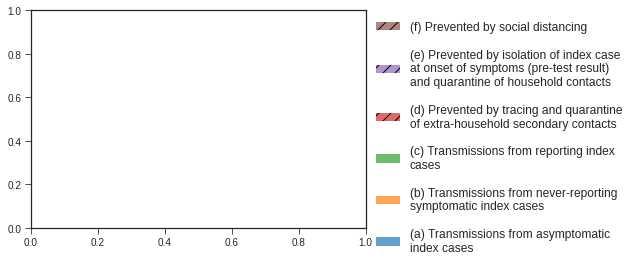

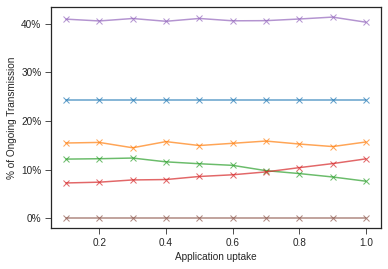

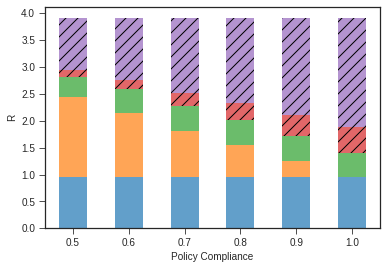

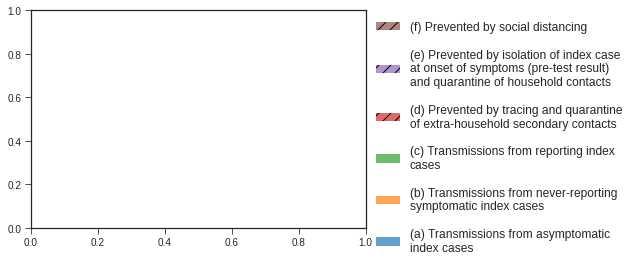

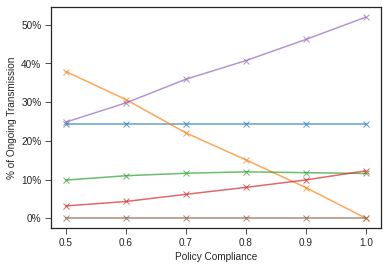

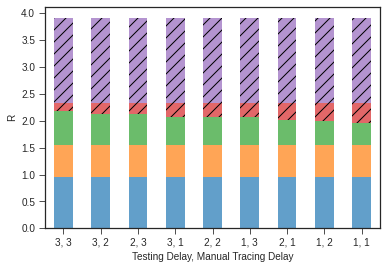

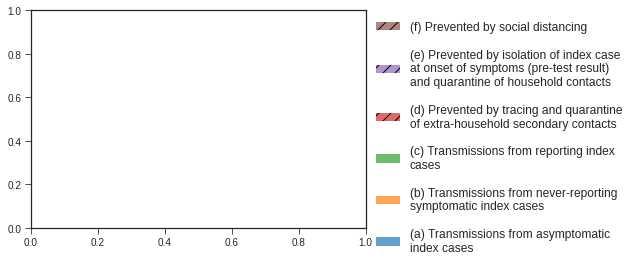

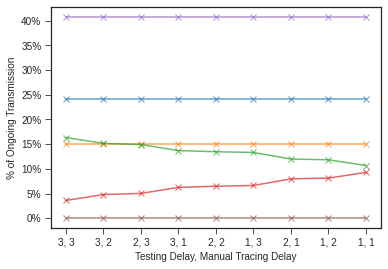

2


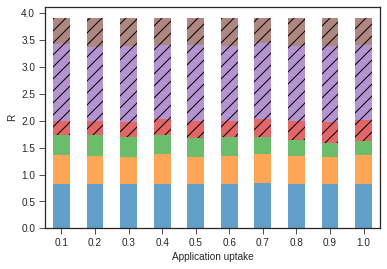

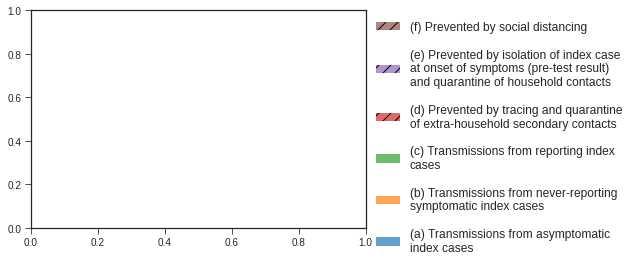

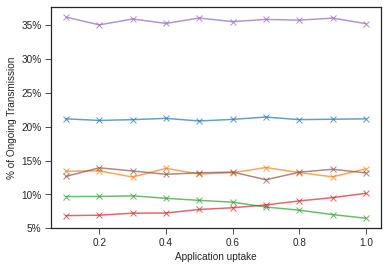

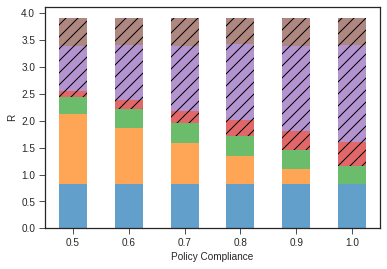

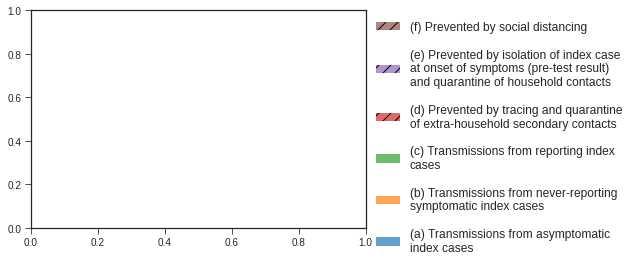

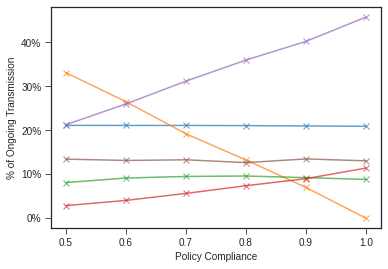

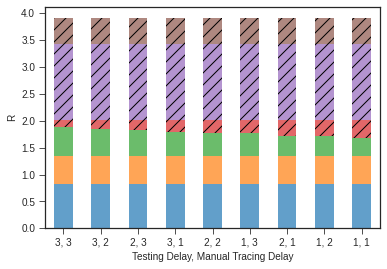

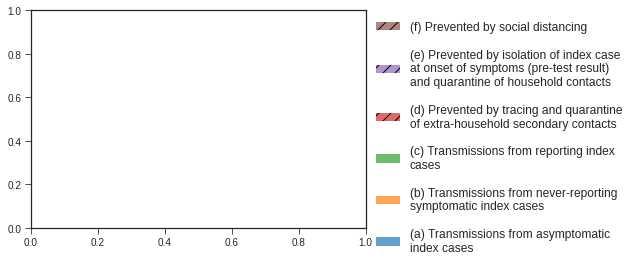

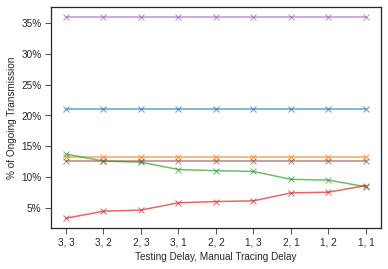

3


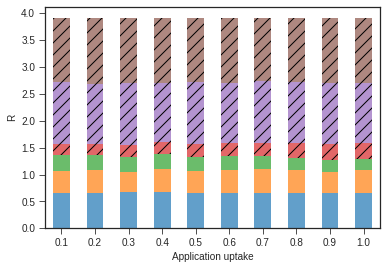

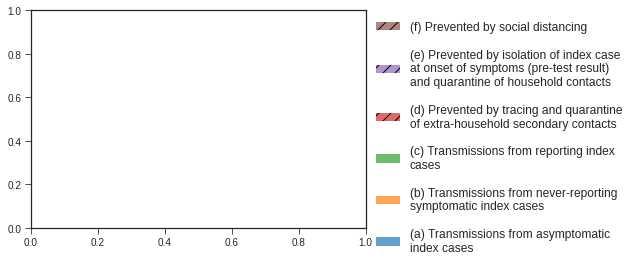

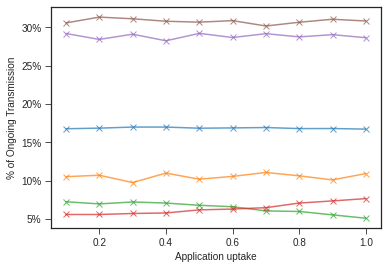

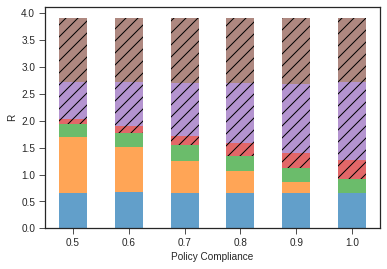

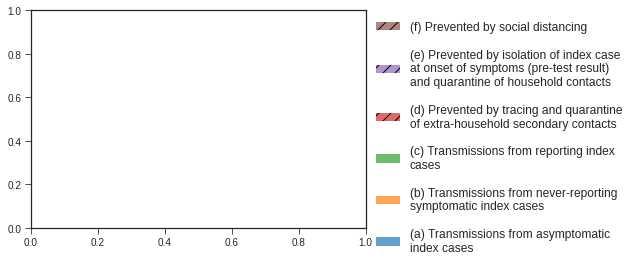

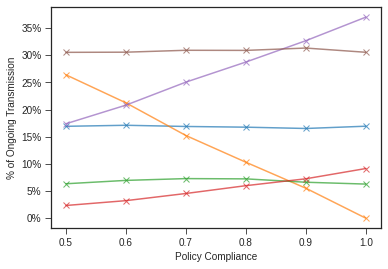

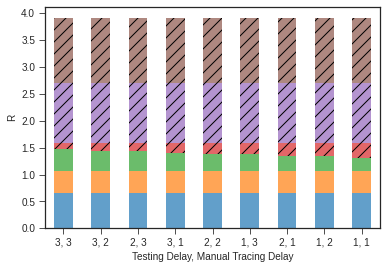

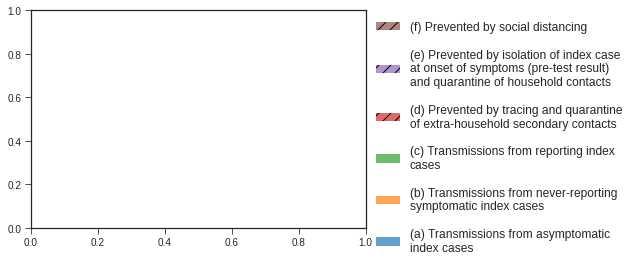

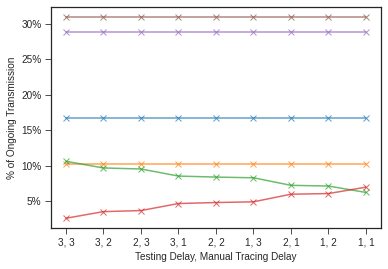

4


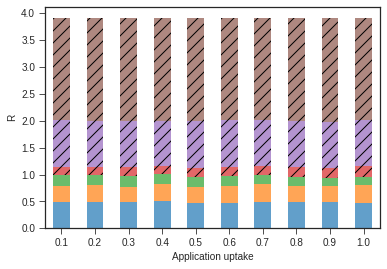

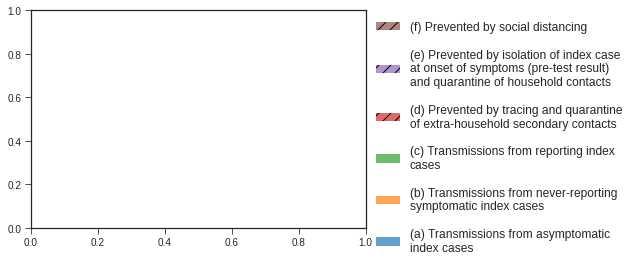

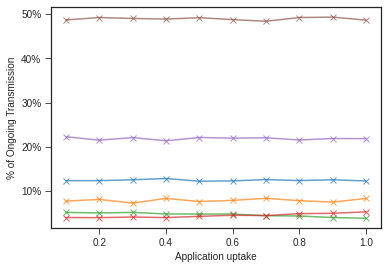

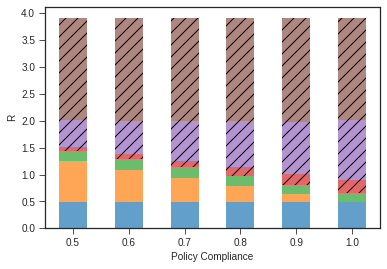

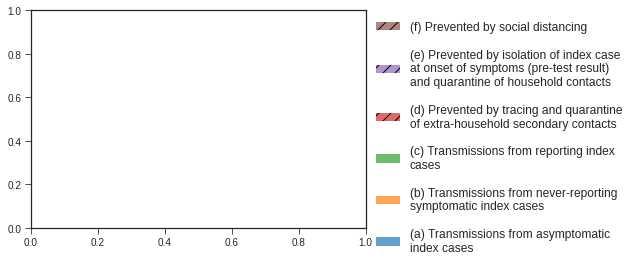

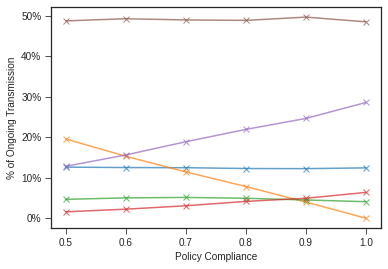

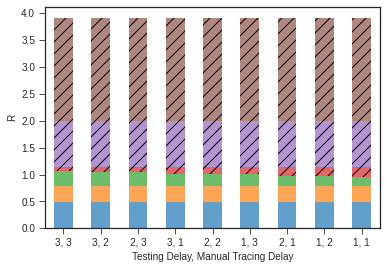

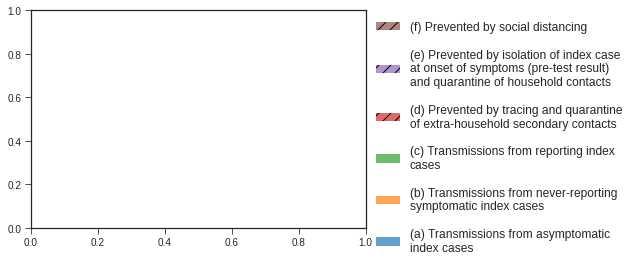

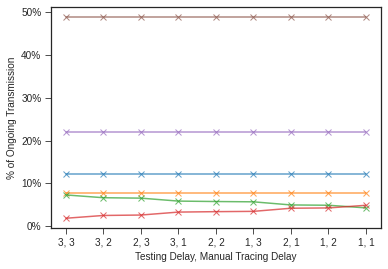

5


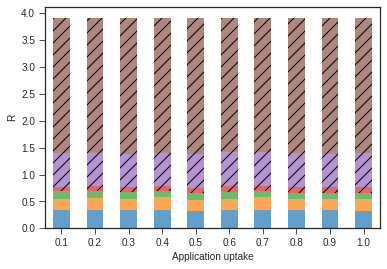

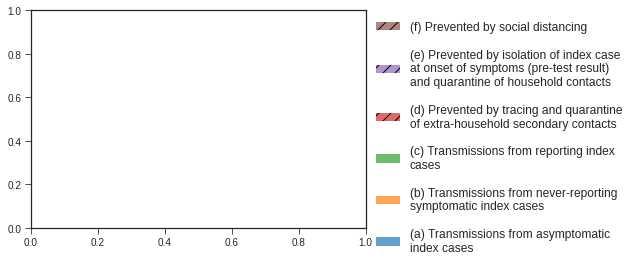

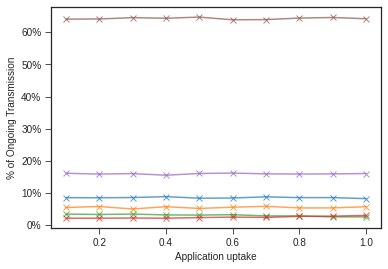

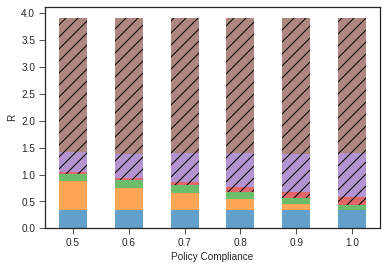

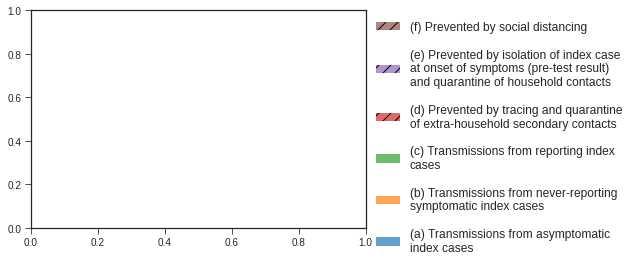

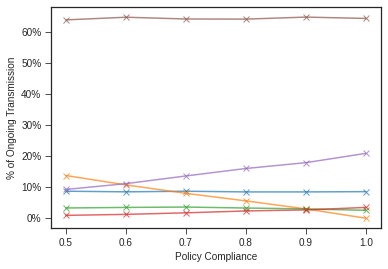

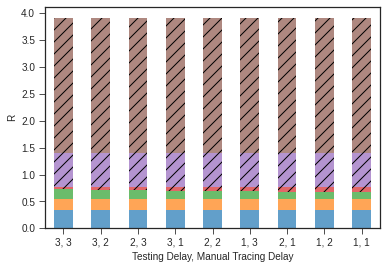

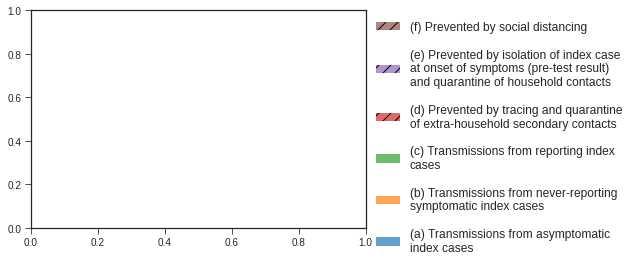

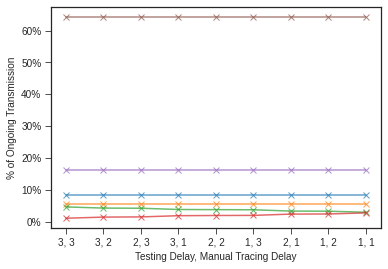

In [94]:
for i in range(1, 6):
    print(i)
    app_uptake_sensitivity = load_sensitivity_folder(
        outputs_dir = f"../runs/sensitivity/app_cov/S{i}_test_based_TTI",
        config_keys  = ["app_cov"] ,
        config_pretty_names = ["Application uptake"],
    )

    trace_adherance_sensitivity = load_sensitivity_folder(
        outputs_dir = f"../runs/sensitivity/trace_adherence/S{i}_test_based_TTI",
        config_keys  = ["trace_adherence"] ,
        config_pretty_names = ["Policy Compliance"],
    )

    delay_sensitivity = load_sensitivity_folder(
        outputs_dir = f"../runs/sensitivity/delays/S{i}_test_based_TTI",
        config_keys  = ["testing_delay", "manual_trace_delay"] ,
        config_pretty_names = ["Testing Delay", "Manual Tracing Delay"],
    )

    plot_hashed_bars(app_uptake_sensitivity.xs('mean', level=1) * 0.0392, hatch_indicies=[3,4,5], save_fig=f'../outputs/charts/S{i}/app_uptake_stacked_bars')
    plot_lines(app_uptake_sensitivity.xs('mean', level=1), save_fig=f'../outputs/charts/S{i}/app_uptake_lines')

    plot_hashed_bars(trace_adherance_sensitivity.xs('mean', level=1) * 0.0392, hatch_indicies=[3,4,5], save_fig=f'../outputs/charts/S{i}/policy_adherence_stacked_bars')
    plot_lines(trace_adherance_sensitivity.xs('mean', level=1), save_fig=f'../outputs/charts/S{i}/policy_adherence_lines')

    test = delay_sensitivity.copy()
    test.reset_index(inplace=True)

    test['Testing Delay, Manual Tracing Delay'] = test['Testing Delay'].map(str) + ", " + test['Manual Tracing Delay'].map(str)
    test['sort_column'] = test['Testing Delay'] + test['Manual Tracing Delay']
    test.sort_values(by=['sort_column', 'Testing Delay'], ascending=False, inplace=True)
    test.drop(columns=[
        'Testing Delay',
        'Manual Tracing Delay',
        'sort_column'
    ], inplace=True)
    test.set_index(['Testing Delay, Manual Tracing Delay', 'statistic'], inplace=True)

    plot_hashed_bars(test.xs('mean', level=1) * 0.0392, hatch_indicies=[3,4,5], save_fig=f'../outputs/charts/S{i}/delay_sorted_stacked_bars')
    plot_lines(test.xs('mean', level=1), save_fig=f'../outputs/charts/S{i}/delay_sorted_lines')

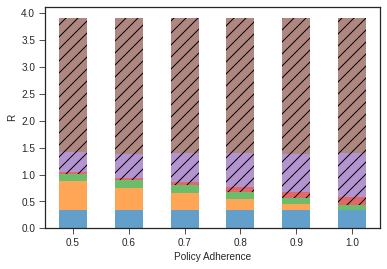

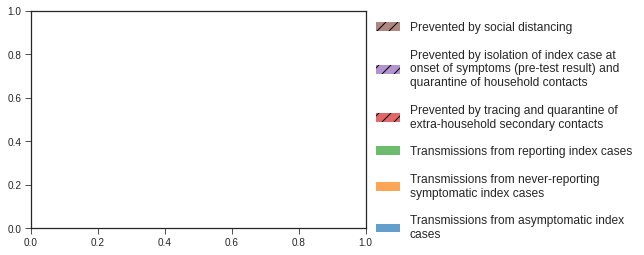

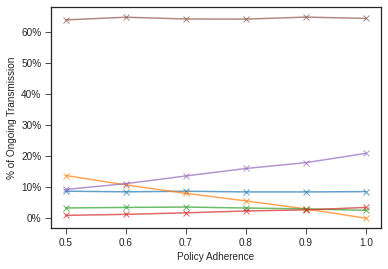

In [87]:
# trace_adherance_sensitivity = load_sensitivity_folder(
#     outputs_dir = "../runs/sensitivity/S3_trace_adherence/S3_test_based_TTI",
#     config_keys  = ["trace_adherence"] ,
#     config_pretty_names = ["Policy Adherence"],
# )

plot_hashed_bars(trace_adherance_sensitivity.xs('mean', level=1) * 0.0392, hatch_indicies=[3,4,5], save_fig='../outputs/charts/policy_adherence_stacked_bars')
plot_lines(trace_adherance_sensitivity.xs('mean', level=1), save_fig='../outputs/charts/policy_adherence_lines')

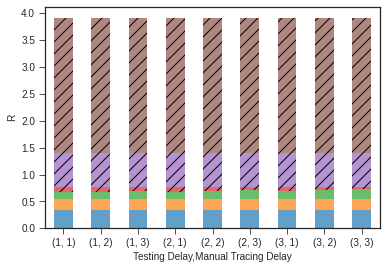

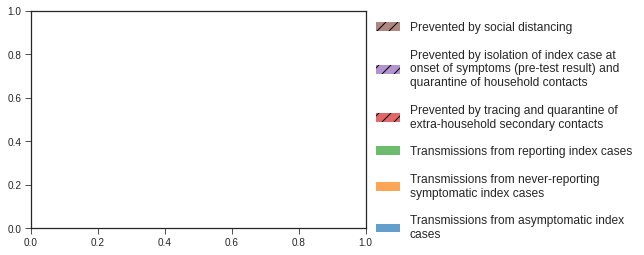

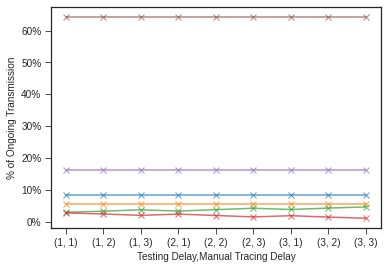

In [88]:
plot_hashed_bars(delay_sensitivity.xs('mean', level=2) * 0.0392, hatch_indicies=[3,4,5], save_fig='../outputs/charts/delay_stacked_bars')
plot_lines(delay_sensitivity.xs('mean', level=2), save_fig='../outputs/charts/delay_lines')

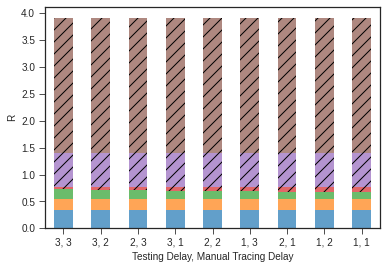

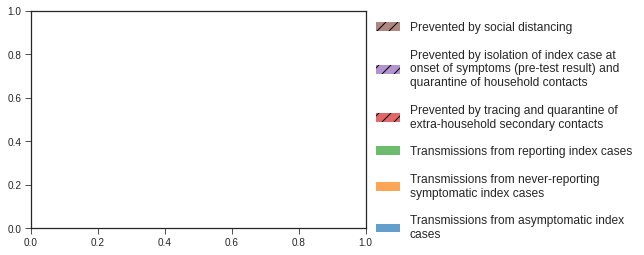

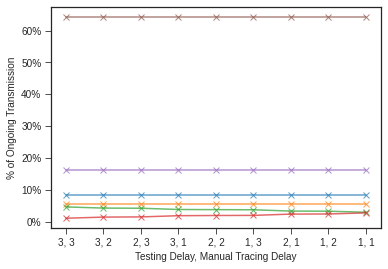

In [89]:
test = delay_sensitivity.copy()
test.reset_index(inplace=True)

test['Testing Delay, Manual Tracing Delay'] = test['Testing Delay'].map(str) + ", " + test['Manual Tracing Delay'].map(str)
test['sort_column'] = test['Testing Delay'] + test['Manual Tracing Delay']
test.sort_values(by=['sort_column', 'Testing Delay'], ascending=False, inplace=True)
test.drop(columns=[
    'Testing Delay',
    'Manual Tracing Delay',
    'sort_column'
], inplace=True)
test.set_index(['Testing Delay, Manual Tracing Delay', 'statistic'], inplace=True)

plot_hashed_bars(test.xs('mean', level=1) * 0.0392, hatch_indicies=[3,4,5], save_fig='../outputs/charts/delay_sorted_stacked_bars')
plot_lines(test.xs('mean', level=1), save_fig='../outputs/charts/delay_sorted_lines')

In [90]:
i=1
app_uptake_sensitivity = load_sensitivity_folder(
        outputs_dir = f"../runs/sensitivity/app_cov/S{i}_test_based_TTI",
        config_keys  = ["app_cov"] ,
        config_pretty_names = ["Application uptake"],
    )

In [91]:
trace_adherance_sensitivity = load_sensitivity_folder(
        outputs_dir = f"../runs/sensitivity/trace_adherence/S{i}_test_based_TTI",
        config_keys  = ["trace_adherence"] ,
        config_pretty_names = ["Policy Adherence"],
    )

In [74]:
i=2
outputs_dir = f"../runs/sensitivity/app_cov/S{i}_test_based_TTI"
files = glob.glob(os.path.join(outputs_dir, '*.json'))
[int(k.split('_')[-1].split('.')[0]) for k in files]

[18, 14, 11, 19, 16, 15, 12, 17, 13, 10]